**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**July, 2023**

---

# Generate cellphoneDB dotplots (infected vs uninfected)

Code to plot the **matching Heatmaps** is in:

*../diffGeneExpression/macrophages/src/heatmaps**

In [12]:
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(pheatmap)
library(cowplot)
library(reshape2)
library(plyr)




format_expression_values = function(celltypes, percent, avgLog2){
    # Function to create a datafram that can be used by ggplot to make dotplots. Dataframe with the format:
    # celltype	gene	percent	zscore_expression	id
    #
    # input
    # percent: dataframe containing the percentage of cells expressing each gene. Columns are cell types, and rows genes.
    # avgLog2: dataframe containing the average log expression of each gene. Columns are cell types, and rows genes.
    # celltypes: list of cell types. Must match with the percent and avgLog2 columns
    
  # subset matrixes with celltypes
  cells = intersect(celltypes, colnames(percent))
  c_percent = as.matrix(percent[, cells])
  c_avgLog2 = avgLog2[, cells]
  # scale avgLog2
  rn = colnames(c_avgLog2)
  avgLog2_scaled = apply(t(c_avgLog2), 2, scale) 
  avgLog2_scaled = t(avgLog2_scaled)
  colnames(avgLog2_scaled) = rn
  
  # format as dataframe for ggplot2
  m_avgLog2 = melt(avgLog2_scaled)
  m_avgLog2$zscore_expression = m_avgLog2$value
  m_percent = melt(c_percent)
  m_percent$percent = m_percent$value * 100
  m_percent$gene = m_percent$Var1
  m_percent$celltype = m_percent$Var2
  m_avgLog2$id = paste(m_avgLog2$Var1, m_avgLog2$Var2)
  m_percent$id = paste(m_percent$Var1, m_percent$Var2)
  mdf = merge(m_avgLog2, m_percent, by = 'id')
  mdf = mdf[ , c('celltype', 'gene', 'percent', 'zscore_expression', 'id') ]
  
  return(mdf)
}




                              
                                  
dotplot_genes2lineageV1 = function(celltypes, genes2plot, mdf, percent_thr = NULL, legend_loc = 'right'){
    # Function return ggplot dotplot, using the expression dataframe generated by format_expression_values.
    # The dotplot has the genes on the Y axis and the celltypes in the X.
    
    # input
    # celltypes: list of cell types. Must match with the percent and avgLog2 columns
    # genes2plot: vector of genes to be plotted.
    # mdf: expression matrix from  format_expression_values function
    # percent_thr: thershold in the percentage to be plotted. Taking only those genes expressed in >= percent_thr
    # legend_loc: location of the legend
    
  
    celltypes = unique(celltypes)
    genes2plot = unique(genes2plot)

    # Subset the genes and columns that must be plotted. Order partners as in previous plot
    mdf = subset(mdf, gene %in% genes2plot)
    mdf = subset(mdf, celltype %in% celltypes)

    # order as in target genes
    plot_df = do.call(rbind, lapply(genes2plot, function(i) subset(mdf, gene == i)  ))                                    
    plot_df$gene = factor(plot_df$gene, levels = genes2plot) # setting the right order of factors -genes                              
    plot_df$celltype = factor(plot_df$celltype, levels = celltypes) # setting the right order of factors - celltypes
    plot_df = unique(plot_df)

    # If the percent_thr is not NULL.
    #Taking only those genes expressed in >= percent_thr
    if( ! is.null(percent_thr) ){
        plot_df$percent = round(plot_df$percent, digits = 0)
        plot_df = subset(plot_df, percent >= percent_thr)
    }
                                  
  ##- Doing the actual plot
    percent_breaks = round_any(seq(0, 80, length.out = 5), accuracy = 10) #breaks in the color scale                                
    P = ggplot(plot_df,  aes(x = celltype,
                           y = gene,
                           color = zscore_expression,
                           size = percent)) +  
    geom_point() +
    #color scales goes blue-gray-red
    scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                          high = brewer.pal(n = 5, name = 'Reds')[4], 
                          mid = 'grey90', name="Mean expression (zscore)" )+
    labs(size="Fraction of cells",col="Mean expression (zscore)") +
    scale_size_continuous(breaks = percent_breaks)+
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title=element_blank(),
          legend.position = legend_loc, legend.margin=margin(),
          #legend.direction = "horizontal", legend.box="vertical", 
          legend.key.height= unit(0.4, 'cm'),
          legend.key.width= unit(0.25, 'cm'),
          legend.text = element_text(size=5), legend.title = element_text(size=5)
          #                                            legend.box.margin=margin(10,-10,10,-10)
    )
    #position of the legen and 'y' axis labes
    if (legend_loc == 'left'){
        P = P + scale_y_discrete(position = "right")
        }
  
    #function returns the ggplot
    return(P)
}





dotplot_genes2lineageV2 = function(celltypes, genes2plot, mdf, percent_thr = NULL, legend_loc = 'bottom'){
    # Function return ggplot dotplot, using the expression dataframe generated by format_expression_values.
    # The dotplot has the genes on the X axis and the celltypes in the Y.
    
    # input
    # celltypes: list of cell types. Must match with the percent and avgLog2 columns
    # genes2plot: vector of genes to be plotted.
    # mdf: expression matrix from  format_expression_values function
    # percent_thr: thershold in the percentage to be plotted. Taking only those genes expressed in >= percent_thr
    # legend_loc: location of the legend
    
    celltypes = unique(celltypes)
    genes2plot = unique(genes2plot)
    
    # Subset the genes and columns that must be plotted. Order partners as in previous plot
    mdf = subset(mdf, gene %in% genes2plot)
    mdf = subset(mdf, celltype %in% celltypes)
    
    # order as in target genes
    plot_df = do.call(rbind, lapply(genes2plot, function(i) subset(mdf, gene == i)  ))                            
    plot_df$gene = factor(plot_df$gene, levels = genes2plot)  # setting the right order of factors -genes                                     
    plot_df$celltype = factor(plot_df$celltype, levels = celltypes) # setting the right order of factors - celltypes
    plot_df = unique(plot_df)

    # If the percent_thr is not NULL.
    #Taking only those genes expressed in >= percent_thr
    if( ! is.null(percent_thr) ){
        plot_df$percent = round(plot_df$percent, digits = 0)
        plot_df = subset(plot_df, percent >= percent_thr)
    }
    
    ##- Doing the actual plot
    percent_breaks = round_any(seq(0, 80, length.out = 5), accuracy = 10)                                
    P = ggplot(plot_df,  aes(x = gene,
                           y = celltype,
                           color = zscore_expression,
                           size = percent)) +  
    geom_point() +
    #color scales goes blue-gray-red
    scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                          high = brewer.pal(n = 5, name = 'Reds')[4], 
                          mid = 'grey90', name="Mean expression (zscore)" )+
    labs(size="Fraction of cells",col="Mean expression (zscore)") +
    scale_size_continuous(breaks = percent_breaks)+
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
          axis.title=element_blank(),
          legend.position = legend_loc, legend.box="vertical", legend.margin=margin(),legend.direction = "horizontal",
          legend.text = element_text(size=5), legend.title = element_text(size=5),
          #                                            legend.box.margin=margin(10,-10,10,-10)
    )
    
    #function returns the ggplot
    return(P)
}

In [2]:
outdir= '../results/images/'

## Plasmodium Dotplot - Figure 3

Code to plot the **matching Heatmap** is in:

*../diffGeneExpression/macrophages/src/heatmaps**

In [1]:
#Loading the data ( Average log expression and percentage of cells expressing the gene)

avgLog2 = read.csv('../data/malaria_inf_average_log_24h.csv', stringsAsFactors = F, row.names=1)
percent = read.csv('../data/malaria_inf_percent_24h.csv', stringsAsFactors = F, row.names=1)
head(percent)

,EVT_1.Pf,EVT_1.UI,EVT_2.Pf,EVT_2.UI,Endo_f.Pf,Endo_f.UI,F.Pf,F.UI,F_p.Pf,F_p.UI,⋯,VCT.Pf,VCT.UI,VCT_CCC.Pf,VCT_CCC.UI,VCT_fusing.Pf,VCT_fusing.UI,VCT_p.Pf,VCT_p.UI,iEVT.Pf,iEVT.UI
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DPP6,0.05,0.05,0.03,0.03,0.03,0.04,0.03,0.04,0.03,0.06,⋯,0.11,0.16,0.06,0.06,0.08,0.08,0.10,0.10,0.05,0.05
LINC02665,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ITCH-IT1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AC100782.1,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
COG4,0.70,0.51,0.23,0.23,0.22,0.26,0.13,0.14,0.41,0.30,⋯,0.65,0.60,0.23,0.19,0.43,0.34,0.69,0.56,0.45,0.44
FDXR,0.35,0.13,0.09,0.06,0.03,0.04,0.02,0.02,0.09,0.07,⋯,0.45,0.38,0.10,0.09,0.15,0.11,0.48,0.36,0.13,0.13


In [3]:
#Categories to plot: Celltype+Infection+Time
others = c( 'PAMM1.Pf','HBC.Pf', 'Endo_f.Pf','PV.Pf','F.Pf','F_p.Pf','F_sm.Pf','VCT.Pf','VCT_fusing.Pf'
            )

In [7]:
#obtaining the 
mdf_others = format_expression_values(others, percent = percent, avgLog2 = avgLog2)
head(mdf_others)

,celltype,gene,percent,zscore_expression,id
,<fct>,<fct>,<dbl>,<dbl>,<chr>
1,Endo_f.Pf,A1BG,12,-0.62469389,A1BG Endo_f.Pf
2,F_p.Pf,A1BG,43,-0.03745190,A1BG F_p.Pf
3,F_sm.Pf,A1BG,77,2.11689344,A1BG F_sm.Pf
4,F.Pf,A1BG,36,0.19322345,A1BG F.Pf
5,HBC.Pf,A1BG,4,-0.81183264,A1BG HBC.Pf
6,PAMM1.Pf,A1BG,29,0.03259062,A1BG PAMM1.Pf


In [9]:
rev(Partners)

[1] "MERTK" "CSF3R"

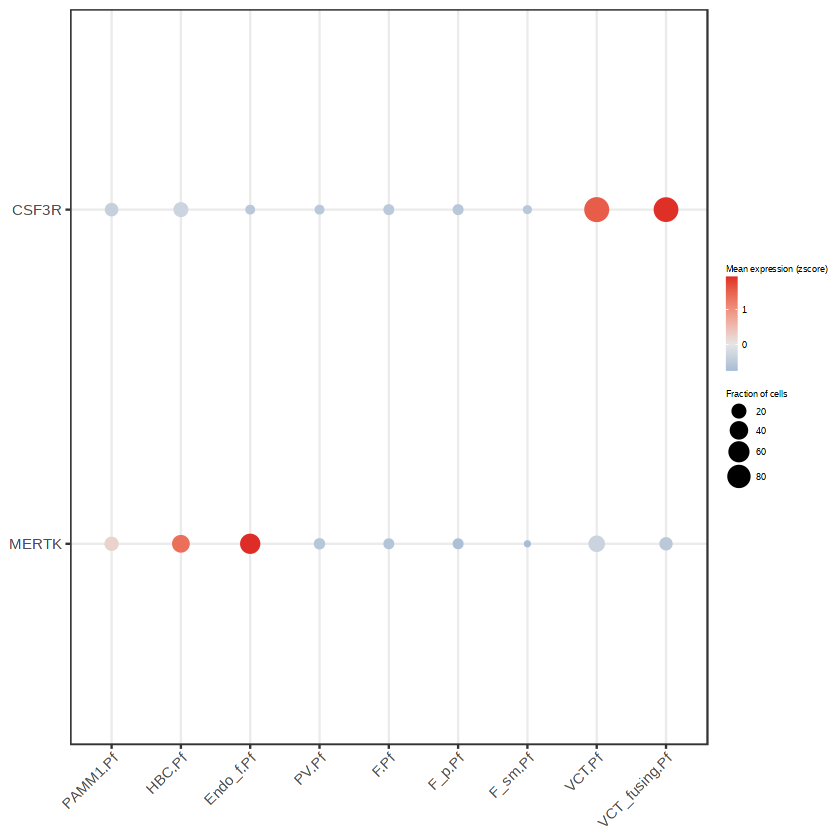

In [11]:
Partners=c('CSF3R','MERTK')


dotplot_genes2lineageV1(others, rev(Partners), mdf_others, legend_loc='right')
ggsave(filename = paste0(outdir,'macrophages_partners_CPDBinteractions_Pfonly.svg'), 
       dpi = 300, width = 4, height = 3)

## Listeria Dotplots - Figure 4

Code to plot the **matching Heatmap** is in:

*../diffGeneExpression/macrophages/src/heatmaps**

In [12]:
#Loading the data ( Average log expression and percentage of cells expressing the gene)

avgLog2 = read.csv('../data/listeria_inf_average_log_24h.csv', stringsAsFactors = F, row.names=1)
percent = read.csv('../data/listeria_inf_percent_24h.csv', stringsAsFactors = F, row.names=1)
head(percent)

,EVT_1.Lm,EVT_1.UI,EVT_2.Lm,EVT_2.UI,Endo_f.Lm,Endo_f.UI,F.Lm,F.UI,F_p.Lm,F_p.UI,⋯,VCT.Lm,VCT.UI,VCT_CCC.Lm,VCT_CCC.UI,VCT_fusing.Lm,VCT_fusing.UI,VCT_p.Lm,VCT_p.UI,iEVT.Lm,iEVT.UI
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DPP6,0.08,0.06,0.04,0.04,0.03,0.03,0.03,0.03,0.04,0.01,⋯,0.18,0.16,0.07,0.04,0.10,0.13,0.12,0.13,0.05,0.04
LINC02665,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
ITCH-IT1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AC100782.1,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
COG4,0.25,0.44,0.21,0.29,0.09,0.18,0.16,0.22,0.33,0.36,⋯,0.47,0.56,0.30,0.32,0.34,0.37,0.63,0.60,0.27,0.37
FDXR,0.17,0.21,0.08,0.14,0.02,0.04,0.03,0.05,0.08,0.13,⋯,0.29,0.33,0.16,0.16,0.12,0.12,0.45,0.42,0.12,0.17


In [16]:
#Categories to plot: Celltype+Infection+Time
others = c('PAMM1.Lm','HBC.Lm', 'Endo_f.Lm','PV.Lm','F.Lm','F_p.Lm','F_sm.Lm','VCT.Lm','VCT_fusing.Lm'
            )

In [17]:
mdf_others = format_expression_values(others, percent = percent, avgLog2 = avgLog2)
head(mdf_others)

,celltype,gene,percent,zscore_expression,id
,<fct>,<fct>,<dbl>,<dbl>,<chr>
1,Endo_f.Lm,A1BG,13,-0.49491217,A1BG Endo_f.Lm
2,F_p.Lm,A1BG,42,0.08934579,A1BG F_p.Lm
3,F_sm.Lm,A1BG,57,1.57812750,A1BG F_sm.Lm
4,F.Lm,A1BG,31,0.01267169,A1BG F.Lm
5,HBC.Lm,A1BG,3,-0.95886587,A1BG HBC.Lm
6,PAMM1.Lm,A1BG,28,0.46813309,A1BG PAMM1.Lm


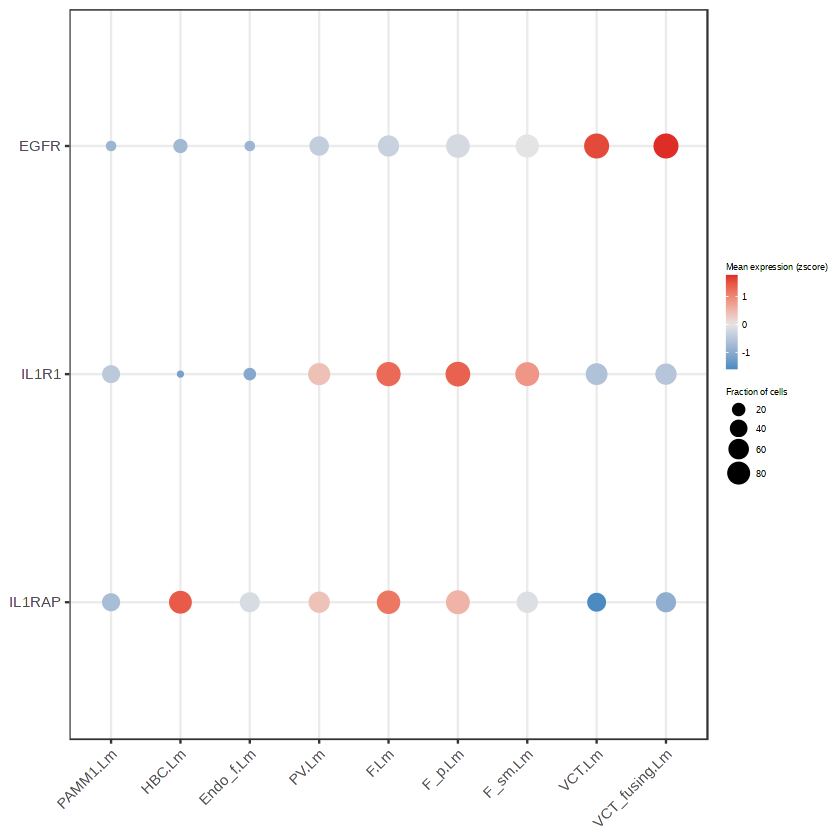

In [19]:
Partners=c('EGFR','IL1R1','IL1RAP')


dotplot_genes2lineageV1(others, rev(Partners), mdf_others, legend_loc='right')
ggsave(filename = paste0(outdir,'macrophages_partners_CPDBinteractions_Lmonly.svg'), 
       dpi = 300, width = 4, height = 3)


## Toxoplasma Dotplots - Figure 4

Code to plot the **matching Heatmap** is in:

*../diffGeneExpression/macrophages/src/heatmaps**

In [4]:
#Loading the data ( Average log expression and percentage of cells expressing the gene)

avgLog2 = read.csv('../data/toxoplasma_inf_average_log_24h.csv', stringsAsFactors = F, row.names=1)
percent = read.csv('../data/toxoplasma_inf_percent_24h.csv', stringsAsFactors = F, row.names=1)
head(percent)

,EVT_1.Tg,EVT_1.UI,EVT_2.Tg,EVT_2.UI,Endo_f.Tg,Endo_f.UI,F.Tg,F.UI,F_p.Tg,F_p.UI,⋯,VCT.Tg,VCT.UI,VCT_CCC.Tg,VCT_CCC.UI,VCT_fusing.Tg,VCT_fusing.UI,VCT_p.Tg,VCT_p.UI,iEVT.Tg,iEVT.UI
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DPP6,0.04,0.04,0.05,0.06,0.03,0.03,0.03,0.03,0.05,0.04,⋯,0.16,0.12,0.06,0.08,0.11,0.11,0.13,0.11,0.05,0.06
LINC02665,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ITCH-IT1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AC100782.1,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.02,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
COG4,0.71,0.55,0.37,0.32,0.20,0.16,0.15,0.14,0.37,0.31,⋯,0.62,0.49,0.30,0.23,0.40,0.34,0.66,0.60,0.51,0.38
FDXR,0.33,0.37,0.14,0.15,0.05,0.04,0.02,0.02,0.07,0.11,⋯,0.32,0.33,0.12,0.16,0.14,0.16,0.43,0.52,0.20,0.15


In [5]:
#Categories to plot: Celltype+Infection+Time
others = c('PAMM1.Tg','HBC.Tg', 'Endo_f.Tg','PV.Tg','F.Tg','F_p.Tg','F_sm.Tg','VCT.Tg','VCT_fusing.Tg') 

In [6]:
mdf_others = format_expression_values(others, percent = percent, avgLog2 = avgLog2)
head(mdf_others)

,celltype,gene,percent,zscore_expression,id
,<fct>,<fct>,<dbl>,<dbl>,<chr>
1,Endo_f.Tg,A1BG,12,-0.67907759,A1BG Endo_f.Tg
2,F_p.Tg,A1BG,43,-0.09054322,A1BG F_p.Tg
3,F_sm.Tg,A1BG,84,1.88505384,A1BG F_sm.Tg
4,F.Tg,A1BG,35,-0.05191687,A1BG F.Tg
5,HBC.Tg,A1BG,3,-0.88110842,A1BG HBC.Tg
6,PAMM1.Tg,A1BG,47,0.56368023,A1BG PAMM1.Tg


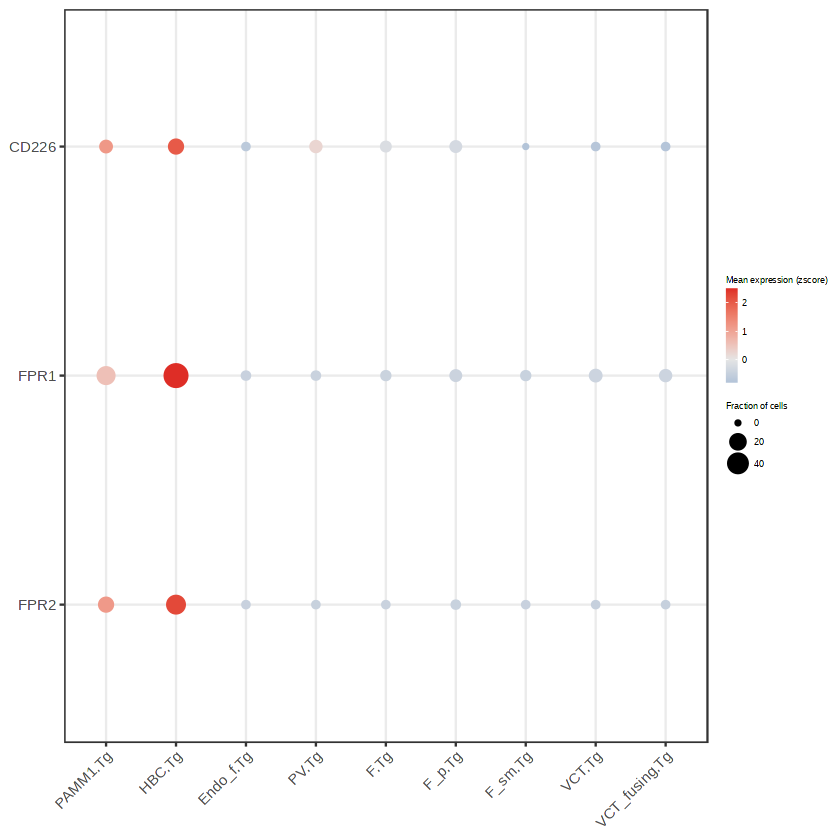

In [7]:
Partners=c('CD226','FPR1','FPR2')


dotplot_genes2lineageV1(others, rev(Partners), mdf_others, legend_loc='right')
ggsave(filename = paste0(outdir,'macrophages_partners_CPDBinteractions_Tgonly.svg'), 
       dpi = 300, width = 4, height = 3)

In [13]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] plyr_1.8.6         reshape2_1.4.4     cowplot_1.1.1      pheatmap_1.0.12   
[5] RColorBrewer_1.1-3 dplyr_1.0.5        ggplot2_3.3.6     

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.11       pillar_1.5.1      compiler_4.0.4    base64enc_0.1-3  
 [5] t